## Machine Failure Prediction using Machine Learning
Author: Chen ZhuoFan (P2100746) | Singapore Polytechnic

Globalisation is the process of interaction and integration among people,companies and governments worldwide.It has accelerated since the 18th century and have enabled the trade of goods and services at a bigger scale.[1]

The production of goods need to be done more effectively.In today's world, many goods are manufacturing by machines in a pipeline to ensure high efficiency and precision at the same time. However,machines may malfunction with time.These malfunctioning machines may result in defects in goods which is not favourable. Manual checking can be time-consuming and cost-inefficient.[2]

Machine Learning is defined by Mitchell (1997) as the study of computer algorithms that improve automatically through experience. [3] Machine learning comes to our sight in the recent decades with its ease and high performance. It has the capacity to learn and identify patterns from data and make decision.[4]

In this experiment ,we will make use of machine learning model to assist us in predicting malfunctioning machines so that repairs or replacements can be done in time to reduce disruption and loss.


## Problem Statement

How can we make use of machine learning to predict malfunctioning machines in the factories?

## Importing Libraries

In [1]:
!pip install numpy matplotlib pandas seaborn scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno mlxtend --user 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")



# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import recall_score,classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import ConfusionMatrixDisplay



# Missing Value
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.impute import KNNImputer



# Data Preprocessing
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder,QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import  MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin



# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb


# Feature Importance
from sklearn.inspection import permutation_importance

# Hyperparameter Tuning
from sklearn.model_selection import  GridSearchCV


# Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest,chi2


# Random State
random_state = 0

# Ignore warning
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

#Statistical tools
from scipy import stats

# Oversampling tools
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC, SMOTE



from imblearn.pipeline import Pipeline as imbpipeline

# Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Data Ingestion
We import the factory_data dataset provided by the contributors of this experiment.This dataset consist of of a label named machine status (Machine Status) and 7 independent features as shown below in figure 1.

In [4]:
## Figure 1
machineDf=pd.read_csv("./factory_data (classification).csv",index_col='Unique ID')
machineDf

,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,,,,,,,,
1,K12965,M,24.95,35.45,1551.0,42.8,0,0
2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
3,T20224,L,24.95,35.35,1498.0,49.4,5,0
4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...
19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19998,T83921,M,25.95,NaN,NaN,33.4,22,0


## Data Exploration

### Data Structure
Most features in the dataset are quantitative features (ie. Ambient T(C),Rotation Speed(rpm) and etc). Product ID and Quantity feature are qualitative features.

In [5]:
machineDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product ID            20000 non-null  object 
 1   Quality               19009 non-null  object 
 2   Ambient T (C)         20000 non-null  float64
 3   Process T (C)         19600 non-null  float64
 4   Rotation Speed (rpm)  18812 non-null  float64
 5   Torque (Nm)           20000 non-null  float64
 6   Tool Wear (min)       20000 non-null  int64  
 7   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ MB


### Managing Missing Data

Missing data is defined as the data value that is not stored/defined for a variable in an observation [3]. Missing data in the dataset is very common in research. These missing data can result a significant impact on the experiment. It is important that we detect and manage these missing data well to obtain accurate and reliable data.

In the following figures,we observed that there is missing data in this dataset.Rotation speed has the most number of missing data folllowed by quality and Process T(C).

In [6]:
pd.DataFrame(machineDf.isna().sum().sort_values(ascending=False))

,0
Rotation Speed (rpm),1188
Quality,991
Process T (C),400
Product ID,0
Ambient T (C),0
Torque (Nm),0
Tool Wear (min),0
Machine Status,0


In [7]:
machineDf[machineDf.isnull().any(axis=1)]

,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,,,,,,,,
7,K40563,L,24.95,NaN,NaN,42.4,14,0
11,K30974,NaN,25.25,35.75,1782.0,23.9,24,0
15,T39889,NaN,25.45,36.05,2035.0,19.6,40,0
20,T81915,M,25.75,NaN,1632.0,32.5,55,0
21,S64787,H,25.75,36.15,NaN,42.7,58,0
...,...,...,...,...,...,...,...,...
19982,Z53954,L,25.65,NaN,1353.0,47.0,190,0
19987,S13645,M,25.75,35.55,NaN,42.3,207,0
19992,T72209,M,25.85,35.35,NaN,26.1,5,0


Understanding the reason for missing value are crucial before deciding on the strategy to manage them.
Robin (1976) classified the reasons for missing value into 3 main categories: [11]


    - Missing Completely at Random (MCAR) – The probability of being missing is the same throughout all observations.

    - Missing at Random (MAR)-The probability of being missing is the same in groups defined by observed data.

    - Missing not at random (MNAR) -The varies in probability of being missing are caused by unknown reasons.


<AxesSubplot:title={'center':'Number of missing value in features'}>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


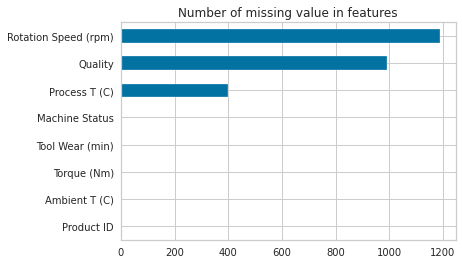

In [8]:
machineDf.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

From the distribution of missing data in the figure below,we observed that the distribution of missing value seems to be random .The probability of being missing is the same throughout all observations.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


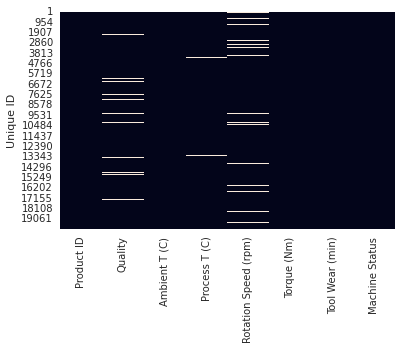

In [9]:
import seaborn as sns
sns.heatmap(machineDf.isnull(), cbar=False)
plt.show()

<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


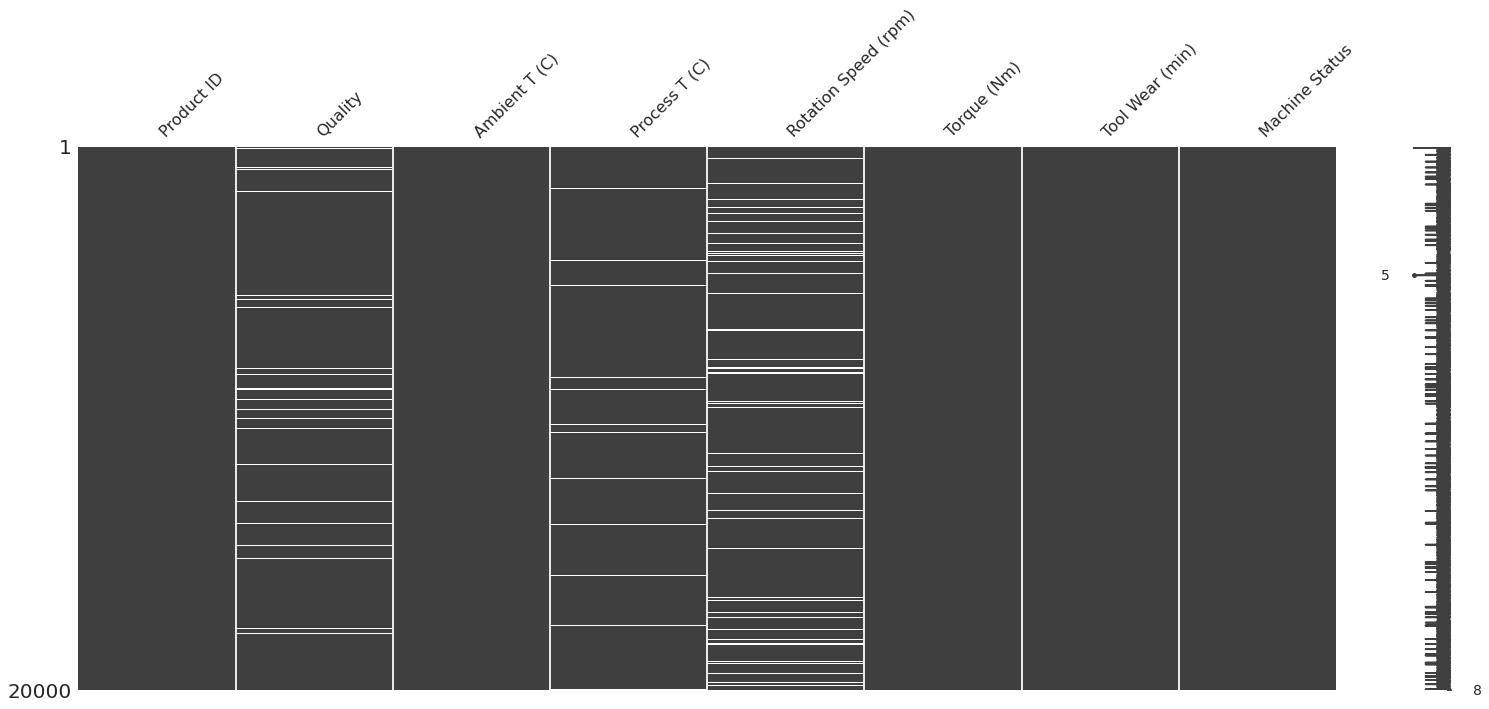

In [10]:
import missingno as msno
msno.matrix(machineDf)

<AxesSubplot:>

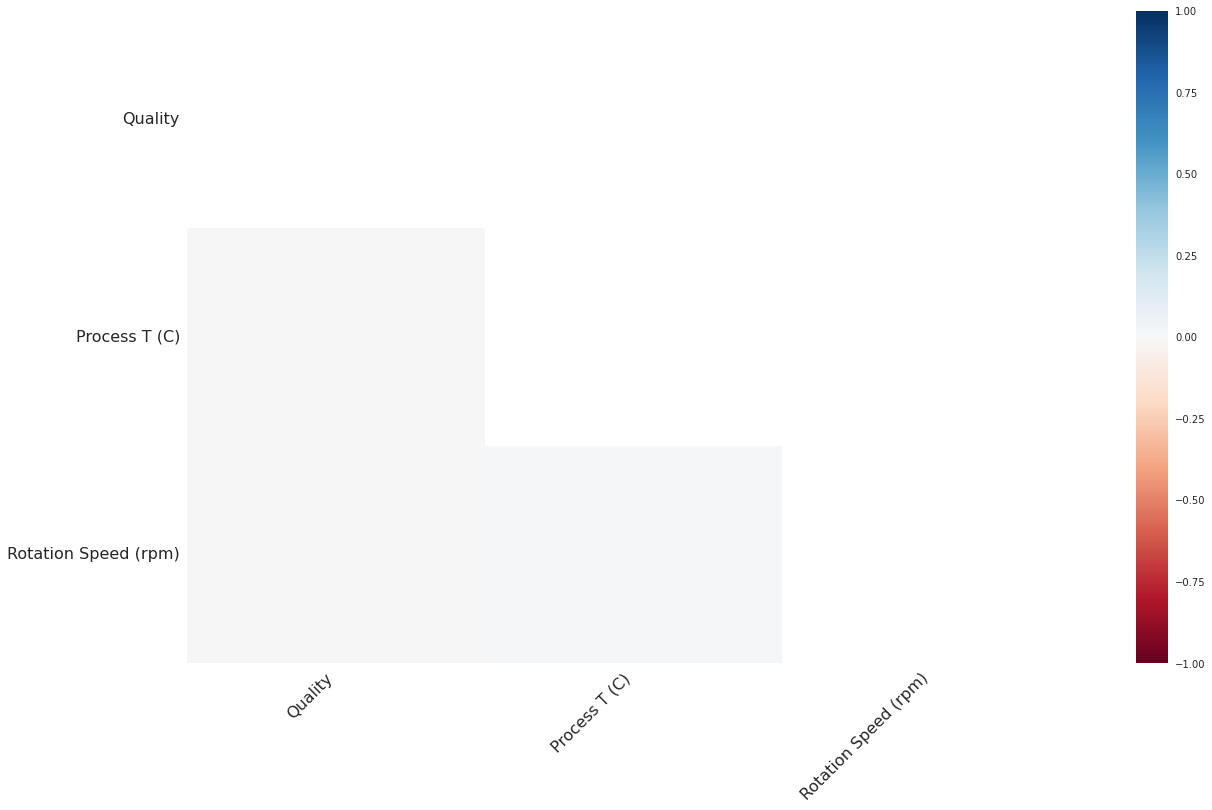

In [11]:
msno.heatmap(machineDf)

### Target Label
Our target label will be the machine status.The label consist of 2 classes : 0 - Normal ,1 -Abnormal. Looking at the distribution of the classess,we observed that the classess are highly imbalanced.The amount of data for which machine fails are much lesser than data for normal machines.Therefore , oversampling need to be introduced later to counter this issue.

Text(0.5, 1.0, 'Distribution of target label')

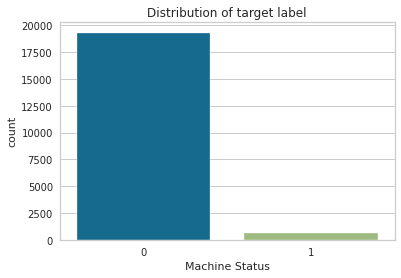

In [12]:
sns.countplot(data=machineDf,x='Machine Status').set_title("Distribution of target label")

### Qualitative Features

In [13]:
qualitativeVariable=['Product ID', 'Quality']

### Qualitative Features

In [14]:
quantitativeVariable=['Ambient T (C)', 'Process T (C)',
       'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']

### Univariate Analysis

From the descriptive statistic for quantitative data ,we observed that

        - The average temperature of machine and environment was 36.9 and 26.9 respectively.
        - The ditrbituion of rotation speed is very likely to skew to the left .
        -There are some machines that rotates extremely fast.The max value and the 75th percentile are very far away.
        - The standard derivative of estimated tool wear timing is relatively high.This indicate high variance in tool wear timing
        -The average torque is around 39.99 Nm.

In [15]:
machineDf[quantitativeVariable].describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
count,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000
mean,26.904930,36.904291,1538.795397,39.986910,107.951000
std,2.000834,1.483647,178.674963,9.968684,63.652555
min,22.150000,32.550000,1168.000000,3.800000,0.000000
25%,25.250000,35.750000,1423.000000,33.200000,53.000000
50%,26.950000,36.950000,1503.000000,40.100000,108.000000
75%,28.450000,37.950000,1613.000000,46.800000,162.000000
max,31.450000,40.750000,2886.000000,76.600000,253.000000


From the descriptive statsitic for categorical data,we observed that

        - More than half (around 57%) of the machine are of low quality
        - Out of 20,000 rows of data ,the product ID has 19,408 of unique data which is expected and might not be useful in machine learning later.
        -Like what we see previously,the machine status label are highly imblanced

In [16]:
descriptive_stats = machineDf.astype('category').describe().T
descriptive_stats["Proportion of Most Frequent Value"] = descriptive_stats["freq"] / len(machineDf.astype('category')) * 100
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,Proportion of Most Frequent Value
Machine Status,20000,2,0,19322,96.61
Quality,19009,3,L,11390,56.95
Process T (C),19600.0,83.0,37.45,575.0,2.875
Ambient T (C),20000.0,94.0,27.55,495.0,2.475
Tool Wear (min),20000,246,0,240,1.2
Torque (Nm),20000.0,577.0,40.2,104.0,0.52
Rotation Speed (rpm),18812.0,941.0,1452.0,93.0,0.465
Product ID,20000,19408,K34631,3,0.015


<AxesSubplot:xlabel='Quality', ylabel='count'>

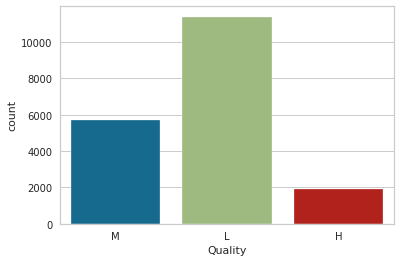

In [17]:
sns.countplot(x='Quality',data=machineDf,)

Looking at the distribution of quantitative features,we observed that

    - The torque , Process T (C) ,Ambient T (C) seems normally distributed.We can test it later
    - The rotation speed is positively skewed.Most data are concentrated at the 1500-1750 rpm range.

array([[<AxesSubplot:title={'center':'Ambient T (C)'}>,
        <AxesSubplot:title={'center':'Process T (C)'}>],
       [<AxesSubplot:title={'center':'Rotation Speed (rpm)'}>,
        <AxesSubplot:title={'center':'Torque (Nm)'}>],
       [<AxesSubplot:title={'center':'Tool Wear (min)'}>, <AxesSubplot:>]],
      dtype=object)

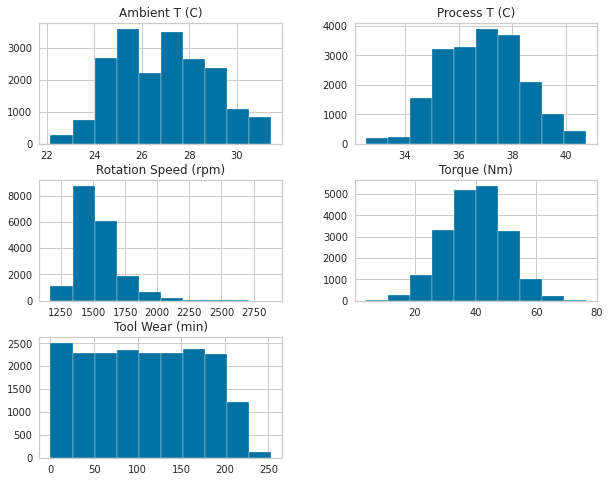

In [18]:
machineDf[quantitativeVariable].hist(figsize=(10,8))

                            H0: Data follow a normal distribution
                            H1: Data does not follow a normal distribution
 We see that the torque has p value > alpha=0.05.Therefore, it is not rare to obtain data of normal distribution.Therefore,we do not reject H0 that data follows a normal distribution.
 
 For Process T (C) and Ambient T (C), we see that the p value is <= alpha=0.05.Therefore, it is rare that we obtain data of normal distribution in these feature.Therefore ,we reject H0.The data does not follows a normal distribution.However,for Process T (C) ,the skew value is still close to 0 .Therefore,we will still consider Process T (C) as normal distribution
 
 In conclusion, we observed that the torque and the process temperature follows a normal distribution.

In [48]:
from scipy.stats import skew
normalTestVar=['Ambient T (C)','Process T (C)','Torque (Nm)']
normalTest=pd.DataFrame({'Feauture':[],'p-value':[],'skew value':[]})
for i in normalTestVar:
    x = machineDf[i].to_numpy()
    k2, p = stats.normaltest(x,nan_policy='omit')
    current=pd.DataFrame({'Feauture':[i],'p-value':[p],'skew value':[  skew(x,nan_policy='omit')]})
    normalTest=pd.concat([normalTest,current])
    
normalTest

,Feauture,p-value,skew value
0,Ambient T (C),0.000000e+00,0.11415
0,Process T (C),1.362288e-80,0.01389396280355725
0,Torque (Nm),8.010457e-01,-0.009515


Upon checking the quantitative features,we realise that there are many outliers for  rotation speed and torque

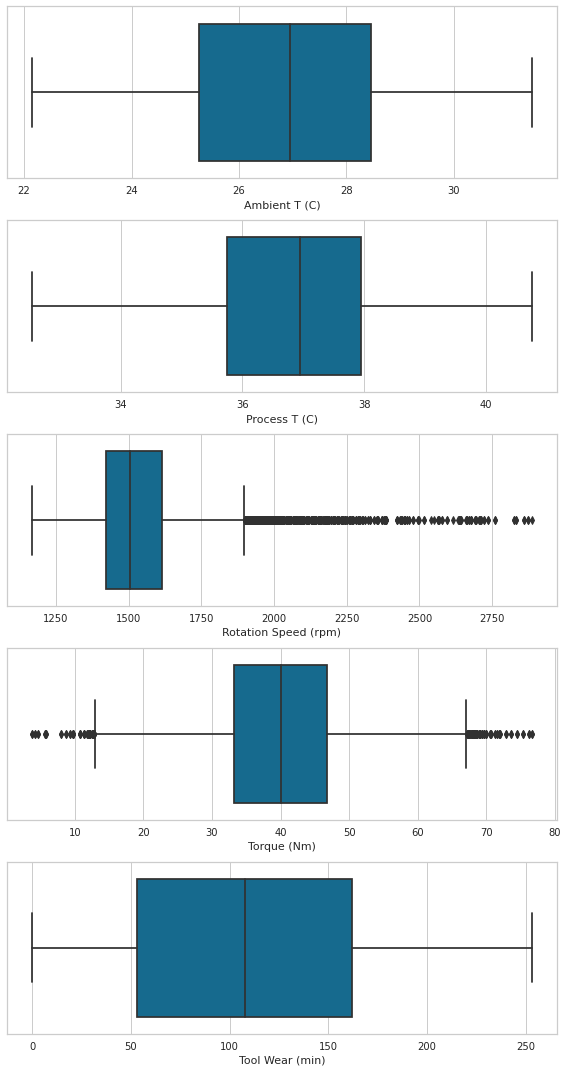

In [19]:
fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariable):
    sns.boxplot(data=machineDf, x=feature, ax = ax[idx])
fig.show()

In [20]:
Q1 = machineDf['Rotation Speed (rpm)'].quantile(0.25)
Q3 = machineDf['Rotation Speed (rpm)'].quantile(0.75)
IQR = Q3 - Q1
machineDf[machineDf['Rotation Speed (rpm)'] >Q3 + 1.5 * IQR].describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,771.000000,757.000000,771.000000,771.000000,771.000000,771.000000
mean,27.163230,37.031242,2103.333333,18.846174,107.712062,0.084306
std,2.062808,1.507887,216.956317,3.588364,65.390417,0.278027
min,22.450000,32.850000,1899.000000,3.800000,0.000000,0.000000
25%,25.350000,35.950000,1950.500000,16.800000,45.000000,0.000000
50%,27.450000,37.250000,2016.000000,19.700000,110.000000,0.000000
75%,28.750000,38.050000,2182.000000,21.500000,165.000000,0.000000
max,31.250000,40.650000,2886.000000,25.000000,244.000000,1.000000


Previously ,we suspect there might be a relationship between torque and rotation.

From the figure below ,we observed that there seems to be a exponential relationship between the 2 variables.As the torque force increase,the rotation speed decreases. 

Torque is the rotational equivalent of linear force. It usually refers tomoment of force or turning effect.

Given the fixed power.The relationship of torque and rotation speed can be seen in this way :
                    $$p = (F . d)/ t $$
             $$ \;\;\;\;\;= (F .2 	\pi r)/t $$
                   $$=  tw \;\;\;\;$$
                   
  
             

 Therefore,
 
 $$ w = p / t $$
 
 
An increase in torque comes with a proportional decrease in rotational speed. There is a inverse relationship in the 2 variables.

Text(0.5, 1.0, 'Relationship between Torque and Rotation Speed')

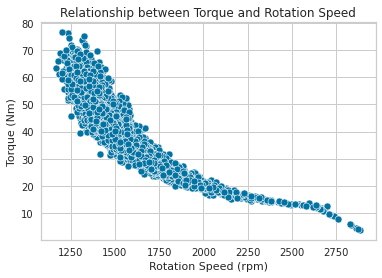

In [21]:
sns.scatterplot(x='Rotation Speed (rpm)',y='Torque (Nm)',data=machineDf).set_title('Relationship between Torque and Rotation Speed')

### Bivariate Analysis

Since the distribution of label class is highly imbalanced,we will use a density distribution plot to better visualised the dat.

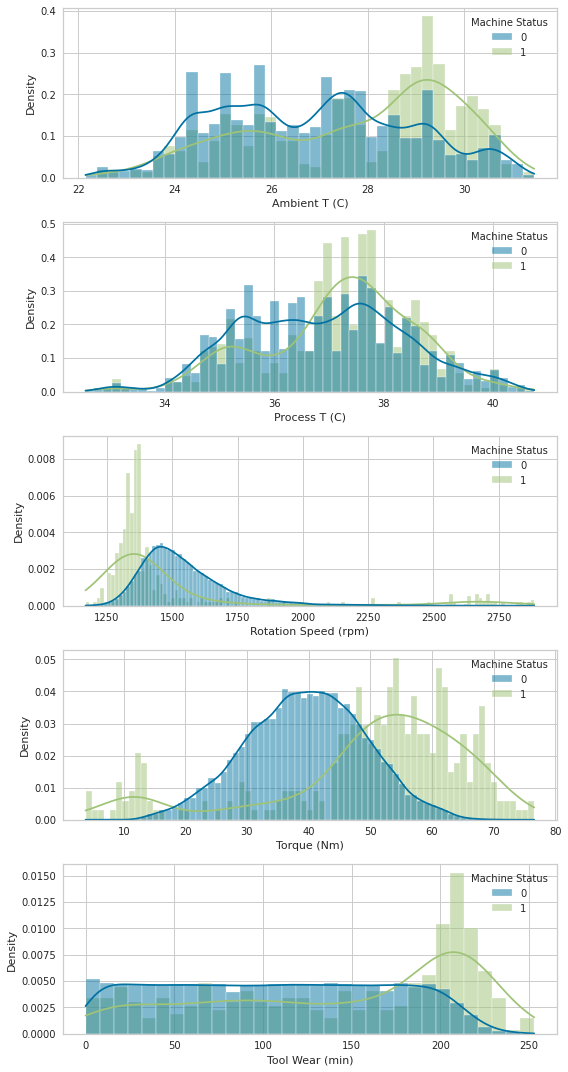

In [49]:
fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariable):

    sns.histplot(data=machineDf,common_norm = False,stat='density', x=feature, hue="Machine Status",ax=ax[idx],kde=True)
fig.show()

For quality,we get the percentage of abnormal machine to normal machine of different quality of machine to give a more precise analysation.The graph below still shows that low quality machine are more likely/easier to be abnormal machine ,followed by medium quanlity and then high quality.

In [61]:
abL=np.sum(machineDf[machineDf['Machine Status']>0]['Quality']=='L')/np.sum(machineDf['Quality']=='L')
abM=np.sum(machineDf[machineDf['Machine Status']>0]['Quality']=='M')/np.sum(machineDf['Quality']=='M')
abH=np.sum(machineDf[machineDf['Machine Status']>0]['Quality']=='H')/np.sum(machineDf['Quality']=='H')
qualityPercentage=pd.DataFrame({'Name':['L','M','H'],'Percentage':[abL,abM,abH]})

<AxesSubplot:xlabel='Name', ylabel='Percentage'>

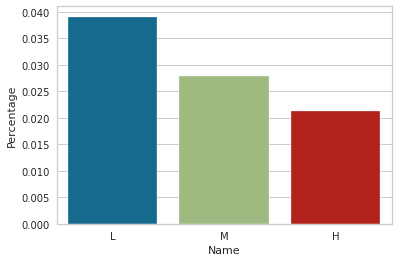

In [63]:
sns.barplot(data=qualityPercentage,x='Name',y='Percentage')

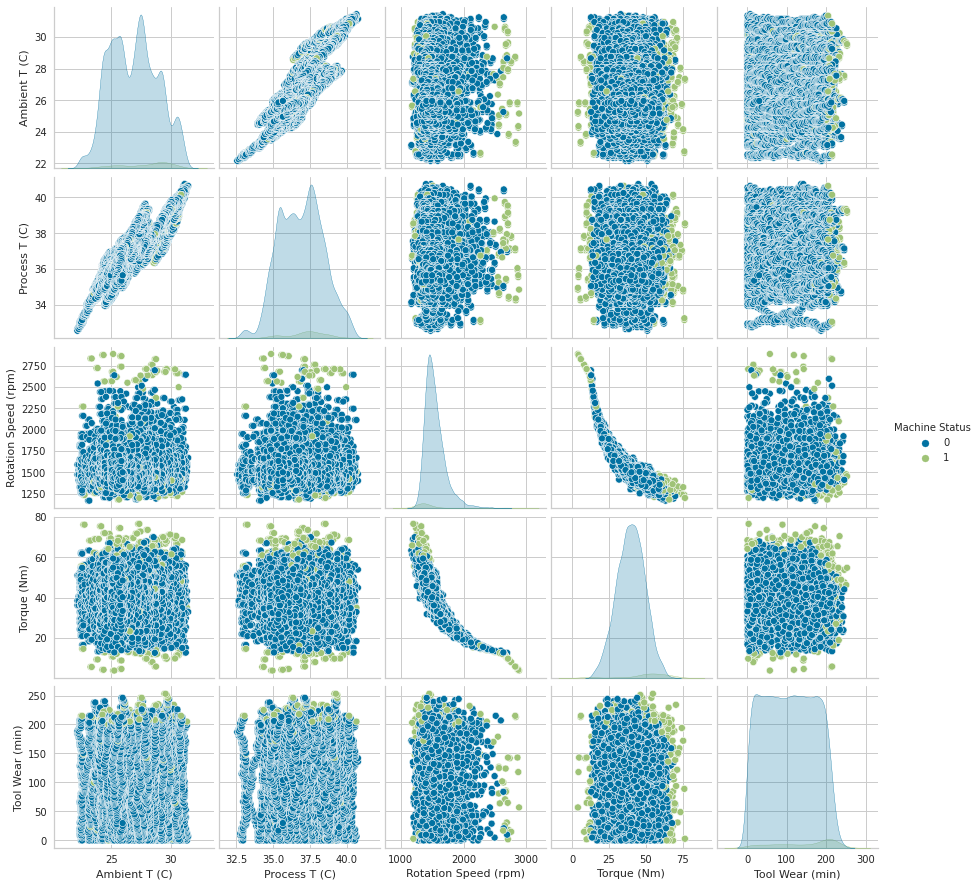

In [64]:
sns.pairplot(machineDf, hue="Machine Status")

From the correlation matrix ,we see that the features are are not highly correlated with the target.The highest was 0.59 from Torque ,followed by rotation speed ,0.45 and tool wear,0.28.
However,between features,we realise that the rotation speed and torque are highly correlated: 0.94.Additionally,we found out the inverse relationship between torque and rotation speed previously.Hence,to reduce computing workload,we can remove one of them.Since rotating speed has many missing values,we will remove rotation speed.

interval columns not set, guessing: ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status']


/home/chzuofa/.local/lib/python3.8/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Product ID is large: 19408. Are you sure this is not an interval variable? Analysis for pairs of variables including Product ID can be slow.
  warnings.warn(


Text(0.5, 1.0, 'Correlation Matrix')

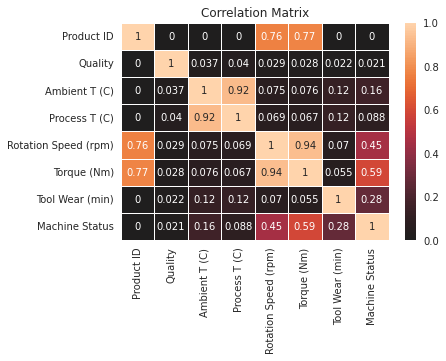

In [26]:
corr_matrix = machineDf.phik_matrix()

sns.heatmap(corr_matrix, annot = True, linewidths=.5,center = 0).set_title('Correlation Matrix')

In [27]:
machineDf=machineDf.drop(['Product ID','Rotation Speed (rpm)'],axis=1)

## Data-Processing

## Training and testing data
Before any data preprocessing ,we shall first carry out data spliting in the ratio of 8:2 and only work on the train data to avoid data leakage.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(machineDf. loc[:, machineDf. columns != 'Machine Status'],machineDf['Machine Status'], random_state = 42, stratify=machineDf['Machine Status'], test_size = .20)
x_train

,Quality,Ambient T (C),Process T (C),Torque (Nm),Tool Wear (min)
Unique ID,,,,,
12792,H,27.35,36.55,43.3,66
6583,L,28.35,37.35,35.7,198
16874,L,27.95,38.35,39.5,75
11392,L,25.85,37.15,8.8,142
4411,L,29.35,37.05,32.2,64
...,...,...,...,...,...
5303,L,30.75,39.95,37.2,195
15452,L,29.95,39.65,48.8,120
18260,L,26.05,37.45,38.4,146


## Feature Scaling and Encoding

### Feature Scaling
The range of values in raw data can varies. This may introduce biasness in machine learning later. Many machines learning algorithm does may not learn properly when this occurs. Feature Scaling is an approach used to normalize the range of features of data. This helps to ensure that all features are weight equally in their representation. In this paper, we will be using the Min-Max scaling to transform all the quantitative variables into the [0,1] range. The minimum and maximum of the feature will be 0 and 1. The calculation of scaled value can be seen in the following equation.

### Encoding Categorical Data
Categorical data are usually encoded with string value. However, most machine learning works better with integer value only. Therefore, there is a need for us to encode these categorical data into numerical data.

Label encoder is one popular approach in achieving this. However, this method brings in issues when there are multiple numbers in the feature, the machine learning model may mistakenly assume that the data is in a certain order correlationship and derive a correlation between the number in the categorical feature and other variable. 

Therefore,One-Hot Encoder will be used in this paper to counter this problem. One-Hot Encoder works by converting each value of the categorical value into a separate new column and assign [0,1] based on its value. 
Since the cardinality of our quality feature is not high and our dataset is relatively big.There is no worry for curve of dimension which is a potentital result of one hot encoder.


In [30]:
quantitativeVariable=['Ambient T (C)', 'Process T (C)', 'Torque (Nm)', 'Tool Wear (min)']


quantitativeTransformer=Pipeline([
     ('Normaliser',MinMaxScaler())
])
categorical_transformers = Pipeline([
    ('One Hot Encoder', OneHotEncoder(handle_unknown='ignore'))
])
data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', quantitativeTransformer, [0,1,2,3]),
       ('Preprocess Categorical Features', categorical_transformers, [4])
])

## Imputation
MissForest is a popular imputation technique that is based on random forest.It can be used to impute missing data particularly for mixed-type data. 
It has the capability of managing continuous and/or categorical data including complex interactions and nonlinearrelations.The out of bag error estimates of random forest anabled it it carry out out imputation error without test set.[5] This imputator was also well-known for it's high accuracy
In this paper,we will be using the MissForest imputator to compensate the missing values.


In [31]:


class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        """ Get either categorical or numerical columns on fit.
        Store as attribute for future reference"""
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        if self.dtype == 'numerical':
            self.cols = X.select_dtypes(exclude='O').columns.tolist()
        elif self.dtype == 'categorical':
            self.cols = X.select_dtypes(include='O').columns.tolist()
        self.col_idx = [machineDf.columns.get_loc(col) for col in self.cols]
        return self

    def transform(self, X):
        """ Subset columns of chosen data type and return np.array"""
        X = X.values if isinstance(X, pd.DataFrame) else X
        return X[:, self.col_idx]

In [32]:

categorical = ['Quality']
numerical = ['Ambient T (C)', 'Process T (C)', 'Torque (Nm)', 'Tool Wear (min)']



num_imp=Pipeline([
 ('num_selector', ColumnSelector('numerical')),
 ('Imputation',IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1),
                           initial_strategy='mean',
                           max_iter=3,skip_complete=True ,random_state=0)),
])

cat_imp=Pipeline([
     ('cat_selector', ColumnSelector('categorical')),
     ('One Hot Encoder1', OrdinalEncoder ()),
     ('Imputation',IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1),
                           initial_strategy='most_frequent',
                           max_iter=3,skip_complete=True,random_state=0)),
])


preproc = FeatureUnion([
    ('num_pipe', num_imp),
    ('cat_pipe', cat_imp)
])

### Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC)
TTo manage the imabalance in target classess,we will be using the Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC) in this paper.

SMOTE was first bought up by Chawla et al.(2002).Compared to the traditional random oversampling ,SMOTE create non-dentical stimulated data which differs from the original data.This is implemented through utilising the k-Nearest Neighbor algorithm where vector between data point and selected neighbor are identified and multiplied by a random number between 0 to 1.However,this technique was only designed for continous features.[6]

To counter this issue ,Chawla et al.(2002) proposed the Synthetic Minority Over-sampling Technique for Nominal and Continuous(SMOTE-NC) which candeal with a mix of continous and nomial features.

In [33]:

colselect=[col in qualitativeVariable for col in machineDf. loc[:, machineDf. columns != 'Machine Status'].columns]

colselect.reverse()


In [34]:
class DfConverter():
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        df = pd.DataFrame(X)     
        return df

    def fit(self, X, y=None):
        return self


In [35]:
class customSelector():
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        return pd.DataFrame(X)[[0,1,2,3,4,5,6]]

    def fit(self, X, y=None):
        return self

## Feature Selection
Feature selection is the process of reducing the number of redundant and irreverent features/dimensions of dataset and selecting the more relevant features. It is widely used by researchers due to the following reason.

    - Simplices the model for easier interpretation and explanations.
     - Reduce time required in training the model.
     - Reduce the curve of dimensionality mentioned in section 3.4.
     
     
 In this paper,we are going to make use of a filter method : Chi-square statistics to select the features that are of the most relevent.

In [36]:
selectionRecord=pd.DataFrame({'no':[],'score':[]})
for i in range(1,8):
    Final = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('Kbest',SelectKBest(chi2,k=i)),
    ('Model',   HistGradientBoostingClassifier())
])
    selectionRecord=pd.concat([selectionRecord,pd.DataFrame({'no':[i],'score':[cross_validate(Final,x_train,y_train,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring=['recall'],n_jobs=-1,return_estimator=True,return_train_score=True)['test_recall'].mean()]})],ignore_index=True)


sns.lineplot(x='no',y='score',data=selectionRecord).set_title('Number of feature selected')

## Evaluation Methodology

In this paper, we will be experimenting 8 models.The model with the highest performance will be selected as the final model.


A baseline classifier will be implemented to determine the bottom line of all models that can be used to compare against other models and further evaluate the performance of model. In this, paper we will be using the Dummy Classifier in scikit-learn.

Accuracy is a type of scoring metric that generally describes how well the model performed over all classes. It highlights the percentage of correct prediction over the total number of predictions. This is calculated by the following formula.[7]
                       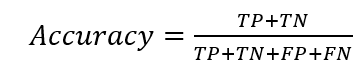

Despite accuracy being the most frequently used in experiments, it is not always suitable. For instance, in prediction of disease, we prefer false positive than false negative as price associated with false negative is very high. It will be a disaster if we diagnose the patient healthy when the patient is already suffering from severe diseases that can cause life threats.[7]








Therefore, we utilized recall as the main scoring metric in the experiment. Recall is calculated by the ratio between the number of true positive to the sum of the number of true positive and false positive. The recall rate will reduce if there are more false negatives.[7]
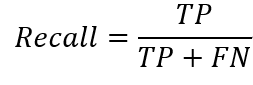


In [37]:
def scoreModel(clf,x,y,algName=None,record=pd.DataFrame({'name':[],'train_accuracy':[],'test_accuracy':[],'test_recall':[],'train_recall':[]})):
    '''
    This function is used for model evaluation . This function use scikit-learn library to carry out cross validation using StratifiedKFold. The scoring metrics are accuracy and balanced accuracy

    :param clf: Classifier 分类器
    :param x:Train Data X(Data)  训练数据 （数据）
    :param y:Train Data Y(Result)  训练数据（结果）
    :param algName: Name of Algorithm used for recording 算法名字
    :param record: History record dataframe 在历史记录上叠加结果
    :return:
    This function return 3 variable: 这个函数返回三个参数
    record: Dataframe with current and past record(if there is any)
    current: Dataframe with current record
    lr: Learning curve
    '''
    score=cross_validate(clf,x,y,cv=StratifiedKFold(n_splits = 5,shuffle = True, random_state = 0),scoring=['accuracy','recall'],n_jobs=-1,return_estimator=True,return_train_score=True)
    current=pd.DataFrame({'name':[algName],'train_accuracy':score['train_accuracy'].mean(),'test_accuracy':score['test_accuracy'].mean(),'test_recall':score['test_recall'].mean(),'train_recall':score['train_recall'].mean()})
    record=pd.concat([record,current],ignore_index=True)
    lr = learning_curve(clf, x, y, scoring = 'recall', cv = StratifiedKFold(n_splits = 5,shuffle = True, random_state = 0), n_jobs=-1)
    return record,current,lr

### Baseline

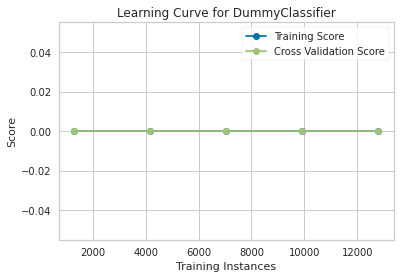

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.966125,0.966125,0.0,0.0


In [38]:

baseline = imbpipeline([

('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('Model', DummyClassifier())
])
record,current,lr=scoreModel(baseline,x_train,y_train,"Dummy Baseline Classifier")
current

### Decision Tree Classifier

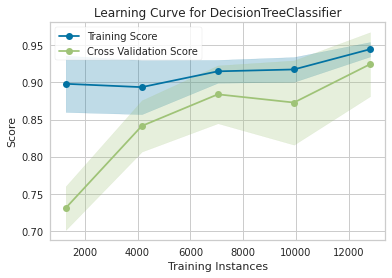

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Decision Tree Classifier,0.877578,0.874875,0.920676,0.945583


In [39]:

DeciTree = imbpipeline([
('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('model', DecisionTreeClassifier(max_depth=9,ccp_alpha=0.000224,max_leaf_nodes=13))
])


record,current,lr=scoreModel(DeciTree,x_train,y_train,"Decision Tree Classifier",record=record)
current

In [40]:
# parameter={'model__max_depth':np.arange(1,10),'model__ccp_alpha':np.arange(0.00827,0.05,0.01)}
# pd.DataFrame(GridSearchCV(DeciTree,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


In [41]:


# from sklearn.model_selection import validation_curve
# pr=np.arange(5,20,1)
# train_score,test_score = validation_curve(DeciTree,x_train,y_train,param_name='model__max_depth',param_range=pr,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring='recall')
# train_score =  np.mean(train_score,axis=1)
# test_score = np.mean(test_score,axis=1)
# plt.plot(pr,train_score,'o-',color = 'r',label = 'training')
# plt.plot(pr,test_score,'o-',color = 'g',label = 'testing')
# plt.legend(loc='best')
# plt.xlabel('number of tree')
# plt.ylabel('accuracy')
# plt.show()



In [42]:
# test_score

### Random Forest Classifier

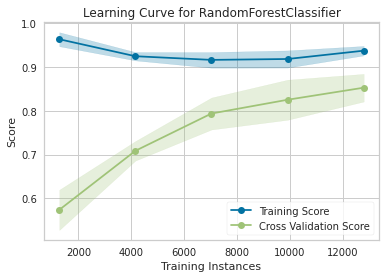

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Random Forest Classifier,0.935859,0.926937,0.856099,0.941876


In [40]:
randomFor = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('model', RandomForestClassifier(max_depth=9,ccp_alpha=0.000224,n_estimators=20,n_jobs=-1))
])
# parameter={'model__max_depth':np.arange(1,9),'model__ccp_alpha':np.arange(0.00827,0.03,0.001)}
# pd.DataFrame(GridSearchCV(randomFor,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)

record,current,lr=scoreModel(randomFor,x_train,y_train,"Random Forest Classifier",record=record)
current

In [44]:
# parameter={'model__max_depth':np.arange(1,10),'model__ccp_alpha':np.arange(0.00827,0.05,0.01)}
# pd.DataFrame(GridSearchCV(randomFor,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


### Support Vector Machine Classifer

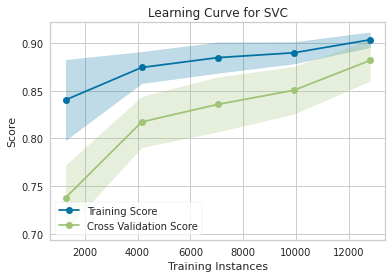

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,SVM Classifier,0.89375,0.893563,0.88561,0.9059


In [41]:
svm = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('model', SVC(gamma=0.5,C=6))
])
# parameters = {'model__kernel':('linear', 'rbf'), 'model__C':np.arange(1,10),}
# pd.DataFrame(GridSearchCV(svm,param_grid=parameters,scoring='recall',n_jobs=-1).fit(x_train,y_train).cv_results_)

record,current,lr=scoreModel(svm,x_train,y_train,"SVM Classifier",record=record)
current

In [46]:
# parameter={'model__C':np.arange(1,10),'model__gamma':np.arange(0.1,1,0.1)}
# pd.DataFrame(GridSearchCV(svm,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)

### Adaptive Boosting Classifier

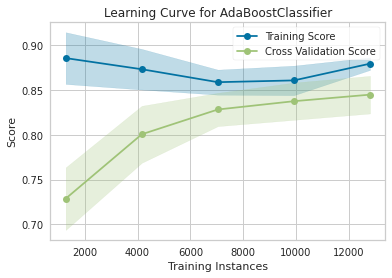

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Adaptive Boosting Classifier,0.910078,0.907687,0.861587,0.876389


In [42]:
adab = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('model', AdaBoostClassifier(learning_rate=0.8))
])


# parameter={'model__n_estimators':np.arange(1,13),'model__learning_rate':np.arange(0.1,2,0.01)}
#
# pd.DataFrame(GridSearchCV(lgbmC,param_grid=parameter,scoring='recall',n_jobs=-1).fit(x_train,y_train).cv_results_)

record,current,lr=scoreModel(adab,x_train,y_train,"Adaptive Boosting Classifier",record=record)
current

### eXtreme Boosting Classifier

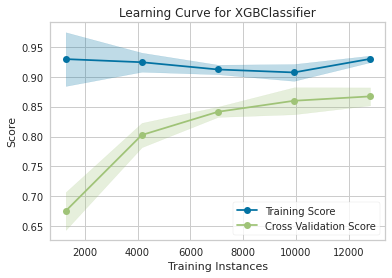

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,eXtreme Gradient Boosting Classifier,0.927797,0.921875,0.881974,0.927125


In [50]:

xgboost = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('Model', xgb.XGBClassifier(tree_method='hist',max_depth=2))
])
record,current,lr=scoreModel(xgboost,x_train,y_train,"eXtreme Gradient Boosting Classifier",record)
current

In [49]:
# parameter={'Model__max_depth':np.arange(1,10),'Model__n_estimators':np.arange(1,16)}
# pd.DataFrame(GridSearchCV(xgboost,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


### Gradient Boosting Classifier

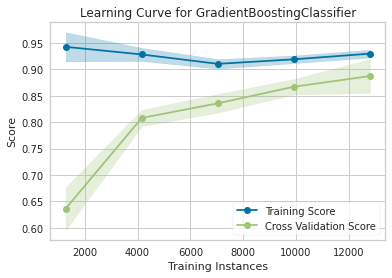

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Gradient Boosting Classifier,0.926266,0.922875,0.893051,0.931269


In [44]:

gboost = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('Model', GradientBoostingClassifier())
])
record,current,lr=scoreModel(gboost,x_train,y_train,"Gradient Boosting Classifier",record)
current

In [90]:
parameter={'Model__max_depth':np.arange(1,8)}
pd.DataFrame(GridSearchCV(gboost,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p21007

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.826487,0.343532,0.332064,0.046959,1,{'Model__max_depth': 1},0.888889,0.870370,0.907407,0.889908,0.917431,0.894801,0.016290,3
1,1.688372,0.133059,0.331537,0.042122,2,{'Model__max_depth': 2},0.898148,0.888889,0.898148,0.944954,0.917431,0.909514,0.020012,1
2,1.798704,0.027728,0.359566,0.007775,3,{'Model__max_depth': 3},0.916667,0.879630,0.879630,0.908257,0.899083,0.896653,0.014971,2
3,1.914522,0.021842,0.355908,0.006571,4,{'Model__max_depth': 4},0.861111,0.833333,0.879630,0.871560,0.880734,0.865274,0.017448,4
4,2.081673,0.062718,0.348648,0.003806,5,{'Model__max_depth': 5},0.851852,0.777778,0.861111,0.880734,0.880734,0.850442,0.038029,5
5,2.152383,0.036436,0.353515,0.011462,6,{'Model__max_depth': 6},0.851852,0.768519,0.870370,0.862385,0.889908,0.848607,0.041938,6
6,2.214194,0.069425,0.348135,0.002205,7,{'Model__max_depth': 7},0.833333,0.759259,0.833333,0.871560,0.853211,0.830139,0.038190,7


### Hist Gradient Boosting Classifier

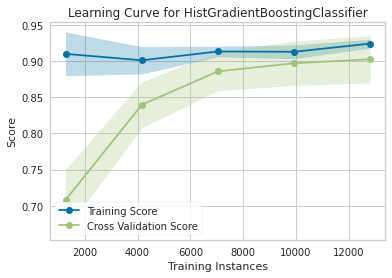

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Hist Gradiet Boosting Tree,0.907203,0.904687,0.904145,0.924812


In [45]:

histboost = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('Model', HistGradientBoostingClassifier(max_depth=2))
])
record,current,lr=scoreModel(histboost,x_train,y_train,"Hist Gradiet Boosting Tree",record)
current

In [80]:
parameter={'Model__max_depth':np.arange(1,8)}
pd.DataFrame(GridSearchCV(histboost,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p21007

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.047042,0.605661,0.323689,0.049753,1,{'Model__max_depth': 1},0.879630,0.879630,0.907407,0.880734,0.908257,0.891131,0.013645,2
1,1.859471,0.048135,0.346832,0.002525,2,{'Model__max_depth': 2},0.898148,0.888889,0.879630,0.917431,0.917431,0.900306,0.015160,1
2,1.828319,0.200585,0.344190,0.074027,3,{'Model__max_depth': 3},0.861111,0.833333,0.888889,0.899083,0.899083,0.876300,0.025587,3
3,2.024913,0.056157,0.354748,0.007363,4,{'Model__max_depth': 4},0.842593,0.824074,0.861111,0.880734,0.880734,0.857849,0.022053,5
4,2.248466,0.053961,0.348682,0.007474,5,{'Model__max_depth': 5},0.861111,0.805556,0.879630,0.889908,0.871560,0.861553,0.029553,4
5,2.356494,0.048897,0.360991,0.012000,6,{'Model__max_depth': 6},0.851852,0.796296,0.870370,0.871560,0.889908,0.855997,0.032187,6
6,2.272737,0.204299,0.334285,0.052749,7,{'Model__max_depth': 7},0.861111,0.805556,0.842593,0.862385,0.834862,0.841301,0.020774,7


C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p2100746\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\p21007

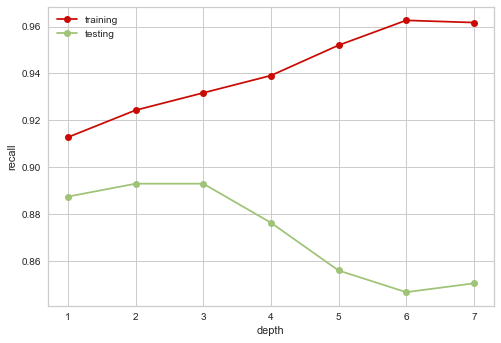

In [82]:


pr=np.arange(1,8)
train_score,test_score = validation_curve(histboost,x_train,y_train,param_name='Model__max_depth',param_range=pr,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring='recall')
train_score =  np.mean(train_score,axis=1)
test_score = np.mean(test_score,axis=1)
plt.plot(pr,train_score,'o-',color = 'r',label = 'training')
plt.plot(pr,test_score,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('recall')
plt.show()


In [ ]:
### k-Nearest Neighbor Classifier

/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeIm

[10:14:13] WARNING: ../src/learner.cc:627: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:14:26] WARNING: ../src/learner.cc:627: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:14:31] WARNING: ../src/learner.cc:627: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but g

/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeIm

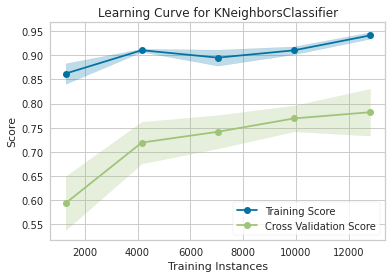

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,K-Nearest Neighbour Classifier,0.962531,0.944875,0.785865,0.940034


In [46]:
knnClassifier = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('Model', KNeighborsClassifier(n_neighbors=5))
])
record,current,lr=scoreModel(knnClassifier,x_train,y_train,"K-Nearest Neighbour Classifier",record=record)
current

In [51]:
# parameter={'Model__n_neighbors':np.arange(1,20)}
# pd.DataFrame(GridSearchCV(knnClassifier,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


## Results and Discussion

Considering both recall and accuracy,we will select Hist Gradient Boosting Classifier as our final model.The model has reach a high test recall of 90.4% and a test accuracy of 90.5%

In [47]:
record

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.966125,0.966125,0.000000,0.000000
1,Decision Tree Classifier,0.877578,0.874875,0.920676,0.945583
2,Random Forest Classifier,0.935859,0.926937,0.856099,0.941876
3,SVM Classifier,0.893750,0.893563,0.885610,0.905900
4,Adaptive Boosting Classifier,0.910078,0.907687,0.861587,0.876389
5,eXtreme Gradient Boosting Classifier,0.929094,0.923563,0.876300,0.920203
6,Gradient Boosting Classifier,0.926266,0.922875,0.893051,0.931269
7,Hist Gradiet Boosting Tree,0.907203,0.904687,0.904145,0.924812
8,K-Nearest Neighbour Classifier,0.962531,0.944875,0.785865,0.940034


## Final Evaluation
In the previous section, we have evaluated that the Hist Gradient Boosting Classifier model has the highest overall performance. Now, we will be testing the model with the independent test data. The final recall score，ROC curve annd the confusion matrix obtained from the final evaluation is shown in figure 8,9 respectively.

### Recall Score
The final recall score obtained was 90.4% which is a relatively high score.This suggests that the model generalize well with unseen data.

In [64]:
Final = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('Model', HistGradientBoostingClassifier(max_depth=2))
])
Final.fit(x_train,y_train)


y_pred=Final.predict(x_test)

recall_score(y_test,y_pred)

/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.9044117647058824

### Feature Importance

In [65]:
imps = permutation_importance(Final, x_test, y_test)
for i in imps.importances_mean.argsort()[::-1]:
     if imps.importances_mean[i] - 2 * imps.importances_std[i] > 0:
         print(f"{x_train.columns[i]:<8}"
               f"{imps.importances_mean[i]:.3f}"
               f" +/- {imps.importances_std[i]:.3f}")
print(imps.importances_mean)

Torque (Nm)0.035 +/- 0.002
Ambient T (C)0.024 +/- 0.004
Process T (C)0.013 +/- 0.002
Tool Wear (min)0.006 +/- 0.001
[-0.0029   0.02445  0.01265  0.0354   0.0058 ]


### Classification Report

In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94      3864
           1       0.23      0.90      0.37       136

    accuracy                           0.90      4000
   macro avg       0.62      0.90      0.66      4000
weighted avg       0.97      0.90      0.92      4000



### ROC Curve
The ROC curve is considered close to the upper left corner,this implies that the model works well.

/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


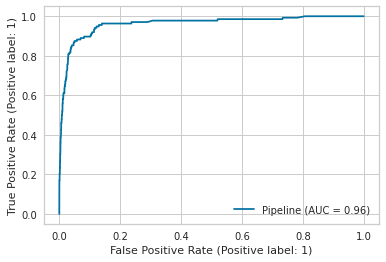

In [67]:
plot_roc_curve(Final,x_test,y_test)

### Confusion Matrix

The confusion matrix shows that it predicted 13 false negatives and 401 false postitives

In [86]:
cm=pd.DataFrame(confusion_matrix(y_test,y_pred)).reindex([1,0])[[1,0]]

,1,0
1,123,13
0,401,3463


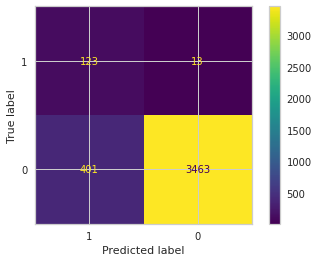

In [88]:

cmg=ConfusionMatrixDisplay(cm.to_numpy(),display_labels=[1,0])
cmg.plot()
plt.show()

## Reference

[1] Exixon, F.,2018."The Economic Benefits of Globalization for Business and Consumers".Available at https://ecipe.org/wp-content/uploads/2018/01/Globalization-paper-final.pdf. [Last accessed on 20/5/2022]

[2] Apica System,2017."Automated vs Manual Testing: Which Should You Use, and When?".Available at https://www.apica.io/difference-between-automated-manual-testing/. [Last accessed on 20/5/2022]

[3] Mitchell, T.,2022.”Machine Learning”. McGraw Hill Education.

[4] Sarker, I. H., ,2021.  “ Machine Learning: Algorithms, Real-World Applications and Research Directions.” SN COMPUT. SCI. 2, 160 [online].Available at https://doi.org/10.1007/s42979-021-00592-x .[Last accessed on 3/5/2022]

[5] Daniel, J. S, Peter, B.,2012." MissForest—non-parametric missing value imputation for mixed-type data". Bioinformatics, Volume 28

[6] Chawla, K. W.,et al.,2002."Smote: Synthetic minority over-sampling technique. "Journalof Artificial Intelligence Research, Available at http://dx.doi.org/10.1613/jair.953. [Last accessed on 20/5/2022]

[7] Metz C. E.,1978.” Basic Principles of ROC Analysis”. Available at https://doi.org/10.1016/s0001-2998(78)80014-2  .[Last accessed on 3/5/2022]